Dating App Analysis 
==

Set up SQLite Database
--

In [1]:
#import required packages 
import pandas as pd 
import sqlite3
import csv

In [2]:
#read in data 
impressions = pd.read_csv('impressions.csv')
transactions = pd.read_csv('transactions.csv')
user_variants = pd.read_csv('user_experiment_variants.csv')

In [3]:
impressions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165531 entries, 0 to 165530
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   memberID      165531 non-null  int64 
 1   impressionID  165531 non-null  object
 2   timestamp     165531 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.8+ MB


In [4]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   memberID   319 non-null    int64  
 1   timestamp  319 non-null    object 
 2   priceGBP   319 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 7.6+ KB


In [5]:
user_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613910 entries, 0 to 613909
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   memberID       613910 non-null  int64 
 1   variant        613910 non-null  object
 2   enteredTestAt  613910 non-null  object
dtypes: int64(1), object(2)
memory usage: 14.1+ MB


In [6]:
#check for duplicate values

print(f"Duplicates in Impressions Dataset is:{impressions.duplicated().sum()},({100*impressions.duplicated().sum()/len(impressions)})%")
print(f"Duplicates in Transactions Dataset is:{transactions.duplicated().sum()},({100*transactions.duplicated().sum()/len(transactions)})%")
print(f"Duplicates in User impressions Dataset is:{user_variants.duplicated().sum()},({100*user_variants.duplicated().sum()/len(user_variants)})%")

Duplicates in Impressions Dataset is:0,(0.0)%
Duplicates in Transactions Dataset is:0,(0.0)%
Duplicates in User impressions Dataset is:0,(0.0)%


In [7]:
#check cardinality of columns

print("cardinality of variables in impressions datasets is:")
print(impressions.nunique())
print('Length of impressions df: ', len(impressions.index))
print("\n","-"*70)
print("\nCardinality of varaibles in transactions datsets is:")
print(transactions.nunique())
print('Length of transactions df: ', len(transactions.index))
print("\n","-"*70)
print("\nCardinality of variables in user experiments datsets is:")
print(user_variants.nunique())
print('Length of user experiments df: ', len(user_variants.index))

cardinality of variables in impressions datasets is:
memberID         46777
impressionID    128707
timestamp       138719
dtype: int64
Length of impressions df:  165531

 ----------------------------------------------------------------------

Cardinality of varaibles in transactions datsets is:
memberID     319
timestamp    319
priceGBP       1
dtype: int64
Length of transactions df:  319

 ----------------------------------------------------------------------

Cardinality of variables in user experiments datsets is:
memberID         613910
variant               3
enteredTestAt    613904
dtype: int64
Length of user experiments df:  613910


In [8]:
# Establish a connection to the database
conn = sqlite3.connect('database.db')

# Create a cursor object
cursor = conn.cursor()

# Define SQL queries to create tables
create_impressions_table = '''CREATE TABLE IF NOT EXISTS impressions (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    memberID INTEGER ,
    impressionID TEXT ,
    timestamp TEXT
)'''

create_transactions_table = '''CREATE TABLE IF NOT EXISTS transactions (
    memberID INTEGER PRIMARY KEY,
    timestamp TEXT,
    priceGBP TEXT
)'''

create_user_experiment_variants_table = '''CREATE TABLE IF NOT EXISTS user_experiment_variants (
    memberID INTEGER PRIMARY KEY,
    variant TEXT,
    enteredTestAt TEXT
)'''

# Execute the SQL queries
cursor.execute(create_transactions_table)
cursor.execute(create_impressions_table)
cursor.execute(create_user_experiment_variants_table)

# Commit the changes
conn.commit()

# Read and insert data from 'impressions.csv'
with open('impressions.csv', 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        cursor.execute('INSERT INTO impressions (memberID, impressionID, timestamp) VALUES (?, ?, ?)', row)


# Read and insert data from 'transactions.csv'
with open('transactions.csv', 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        cursor.execute('INSERT INTO transactions (memberID, timestamp, priceGBP) VALUES (?, ?, ?)', row)


# Read and insert data from 'user_experiment_variants.csv'
with open('user_experiment_variants.csv', 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        cursor.execute('INSERT INTO user_experiment_variants (memberID, variant, enteredTestAt) VALUES (?, ?, ?)', row)

# Commit the changes
conn.commit()

# Close the cursor and the connection
cursor.close()
conn.close()

Data wrangling and EDA
--

In [9]:
#import required packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

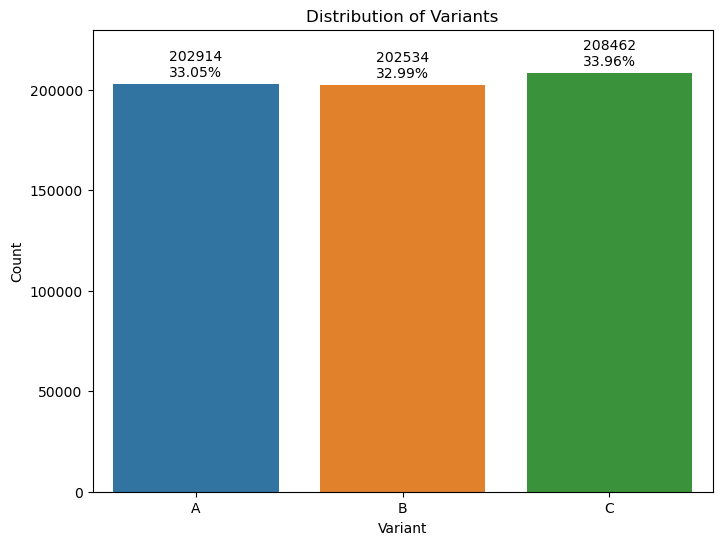

In [10]:
# Sort the DataFrame by 'variant' column
user_variants_sorted = user_variants.sort_values('variant')

# Calculate total count
total_count = len(user_variants_sorted)

# Plotting the countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='variant', data=user_variants_sorted)
plt.title('Distribution of Variants')
plt.xlabel('Variant')
plt.ylabel('Count')

# Adding value counts and ratio to the bars
for p in ax.patches:
    height = p.get_height()
    count_ratio = height / total_count * 100
    ax.annotate(f'{height}\n{count_ratio:.2f}%',
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Adjusting the y-axis limits
plt.ylim(top=ax.get_ylim()[1] * 1.05)  # Increase the y-axis limit by 10%

# Display the chart
plt.show()

In [11]:
#adding conversion rate table to db

conn = sqlite3.connect('database.db')
cursor = conn.cursor()

create_table_query = '''
CREATE TABLE conversion_rate (
    memberID INTEGER PRIMARY KEY,
    variant TEXT,
    timestamp TEXT,
    enteredTestAt TEXT
);
INSERT INTO conversion_rate (memberID, variant, timestamp, enteredTestAt)
SELECT transactions.memberID, user_experiment_variants.variant, transactions.timestamp, user_experiment_variants.enteredTestAt
FROM user_experiment_variants
LEFT JOIN transactions ON transactions.memberID = user_experiment_variants.memberID;
'''
cursor.executescript(create_table_query)

conn.commit()
conn.close()

In [12]:
#converting timestamp to binary value 

conn = sqlite3.connect('database.db')
c = conn.cursor()
df = pd.read_sql_query('SELECT * FROM conversion_rate', conn)
df['converted'] = df['timestamp'].notna().astype(int)
df.to_sql('conversion_rate', conn, if_exists='replace', index=False)
conn.commit()
conn.close()


In [13]:
#create pandas df from new table 

conn = sqlite3.connect('database.db')

# Execute the query and load the result into a DataFrame
df_conversion_rate = pd.read_sql_query("SELECT * FROM conversion_rate", conn)

conn.close()

In [14]:
df_conversion_rate.dtypes

memberID          int64
variant          object
timestamp        object
enteredTestAt    object
converted         int64
dtype: object

In [15]:
#convert date time object columns into date time format 

df_conversion_rate['timestamp'] = pd.to_datetime(df['timestamp'])
df_conversion_rate['enteredTestAt'] = pd.to_datetime(df['enteredTestAt'])

In [16]:
df_conversion_rate.dtypes

memberID                  int64
variant                  object
timestamp        datetime64[ns]
enteredTestAt    datetime64[ns]
converted                 int64
dtype: object

In [17]:
#calculate difference between entered test and transaction in seconds

df_conversion_rate['sec_diff'] = (df_conversion_rate['timestamp'] - df_conversion_rate['enteredTestAt']).dt.total_seconds()

In [18]:
#drop unconverted members

df_converted = df_conversion_rate.dropna()

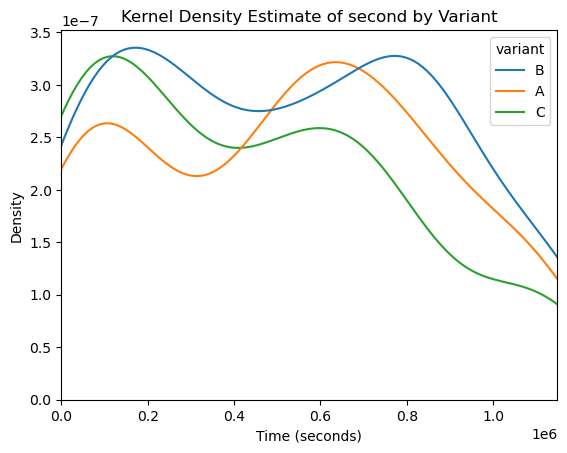

In [19]:
#density plot showing time to conversion 

sns.kdeplot(data=df_converted, x='sec_diff', hue='variant')

# Set x-axis limits
plt.xlim(0, df_conversion_rate['sec_diff'].max())

# Set labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of second by Variant')

# Show the plot
plt.show()

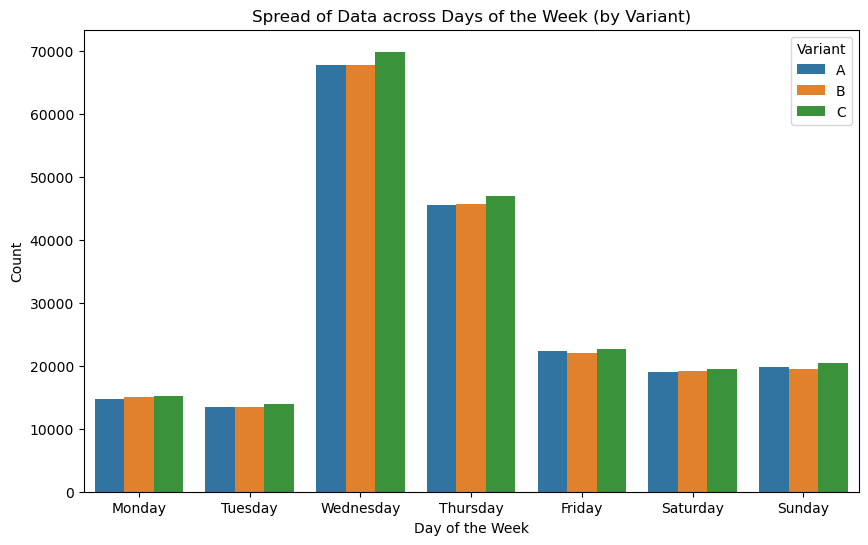

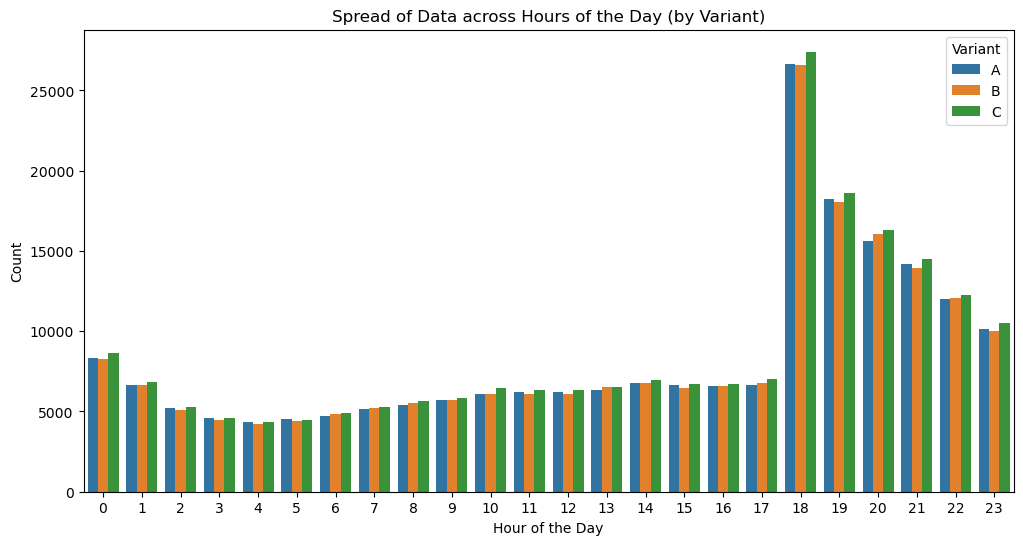

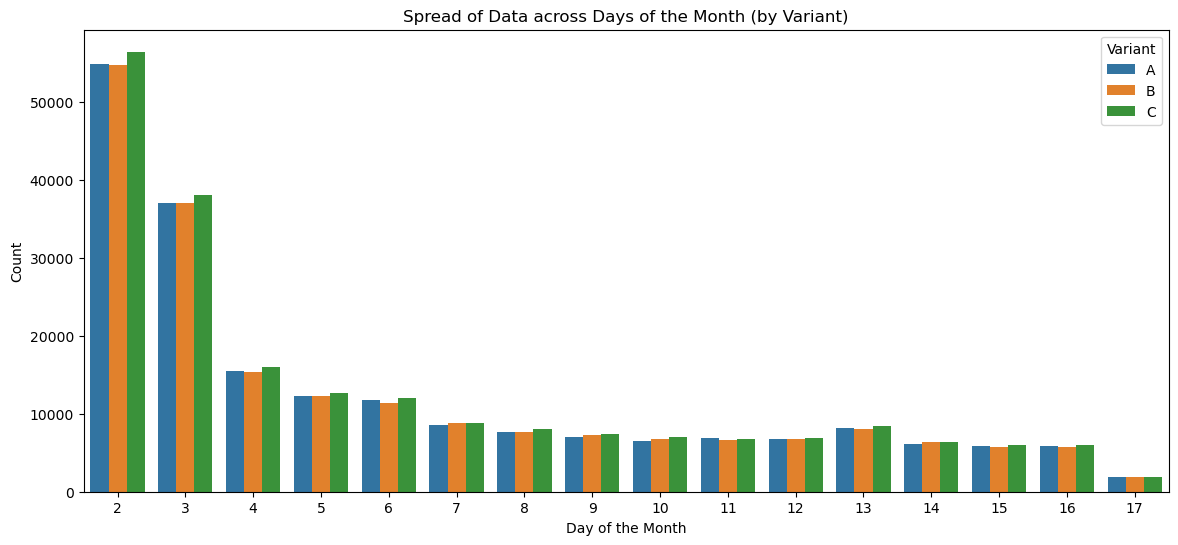

In [20]:
#plots showing distribution of testing across time/ day

# Extract day of the week, hour of the day, and day of the month
df_conversion_rate['day_of_week'] = df_conversion_rate['enteredTestAt'].dt.day_name()
df_conversion_rate['hour_of_day'] = df_conversion_rate['enteredTestAt'].dt.hour
df_conversion_rate['day_of_month'] = df_conversion_rate['enteredTestAt'].dt.day

# Specify the order of days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


# Plotting the spread across days of the week with breakdown by variant
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', hue='variant', data=df_conversion_rate, order= day_order)
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Spread of Data across Days of the Week (by Variant)')
plt.legend(title='Variant')
plt.show()

# Plotting the spread across hours of the day with breakdown by variant
plt.figure(figsize=(12, 6))
sns.countplot(x='hour_of_day', hue='variant', data=df_conversion_rate)
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.title('Spread of Data across Hours of the Day (by Variant)')
plt.legend(title='Variant')
plt.show()

# Plotting the spread across days of the month with breakdown by variant
plt.figure(figsize=(14, 6))
sns.countplot(x='day_of_month', hue='variant', data=df_conversion_rate)
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.title('Spread of Data across Days of the Month (by Variant)')
plt.legend(title='Variant')
plt.show()



C:\Users\44753\AppData\Local\Temp\ipykernel_36128\3160927839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_converted['day_of_week'] = df_converted['timestamp'].dt.day_name()
C:\Users\44753\AppData\Local\Temp\ipykernel_36128\3160927839.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_converted['hour_of_day'] = df_converted['timestamp'].dt.hour
C:\Users\44753\AppData\Local\Temp\ipykernel_36128\3160927839.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

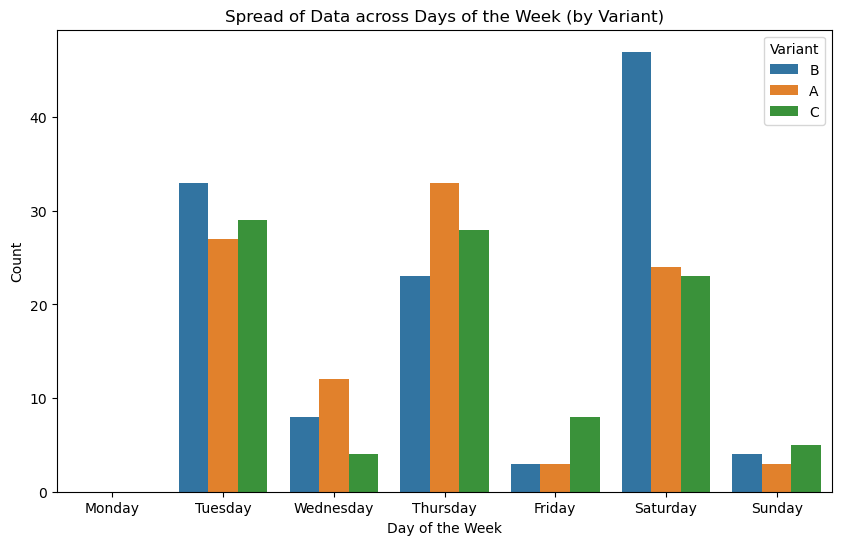

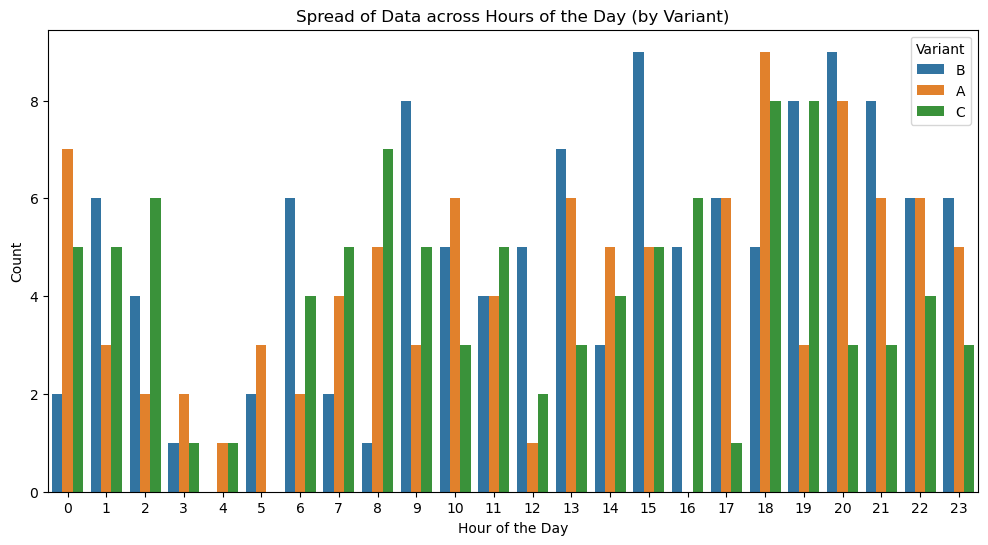

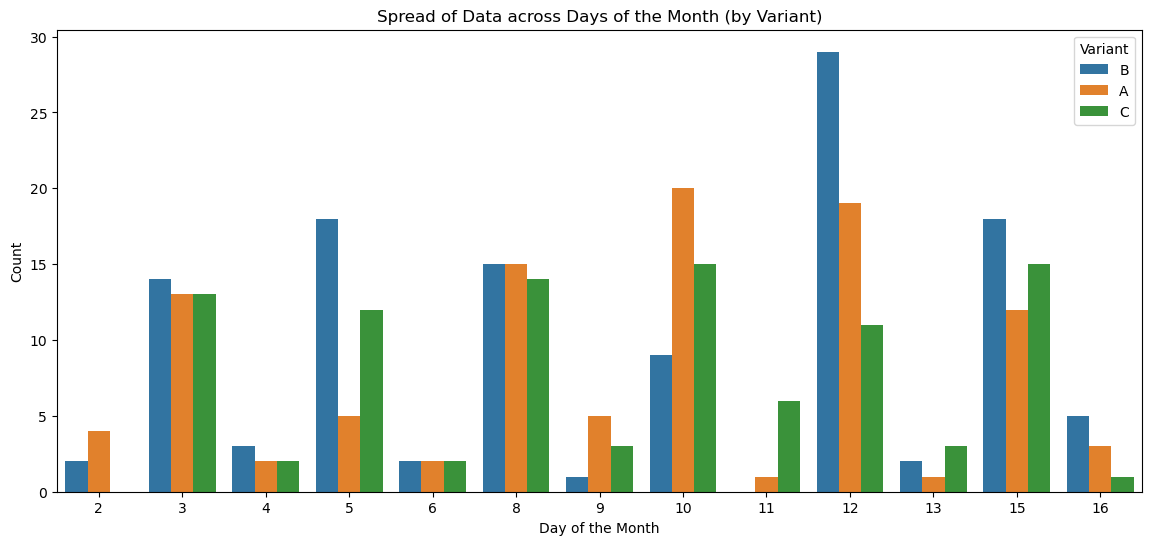

In [21]:
#plots showing distribution of transactions across time/ day


# Extract day of the week, hour of the day, and day of the month
df_converted['day_of_week'] = df_converted['timestamp'].dt.day_name()
df_converted['hour_of_day'] = df_converted['timestamp'].dt.hour
df_converted['day_of_month'] = df_converted['timestamp'].dt.day

# Plotting the spread across days of the week with breakdown by variant
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', hue='variant', data=df_converted, order= day_order)
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Spread of Data across Days of the Week (by Variant)')
plt.legend(title='Variant')
plt.show()

# Plotting the spread across hours of the day with breakdown by variant
plt.figure(figsize=(12, 6))
sns.countplot(x='hour_of_day', hue='variant', data=df_converted)
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.title('Spread of Data across Hours of the Day (by Variant)')
plt.legend(title='Variant')
plt.show()

# Plotting the spread across days of the month with breakdown by variant
plt.figure(figsize=(14, 6))
sns.countplot(x='day_of_month', hue='variant', data=df_converted)
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.title('Spread of Data across Days of the Month (by Variant)')
plt.legend(title='Variant')
plt.show()


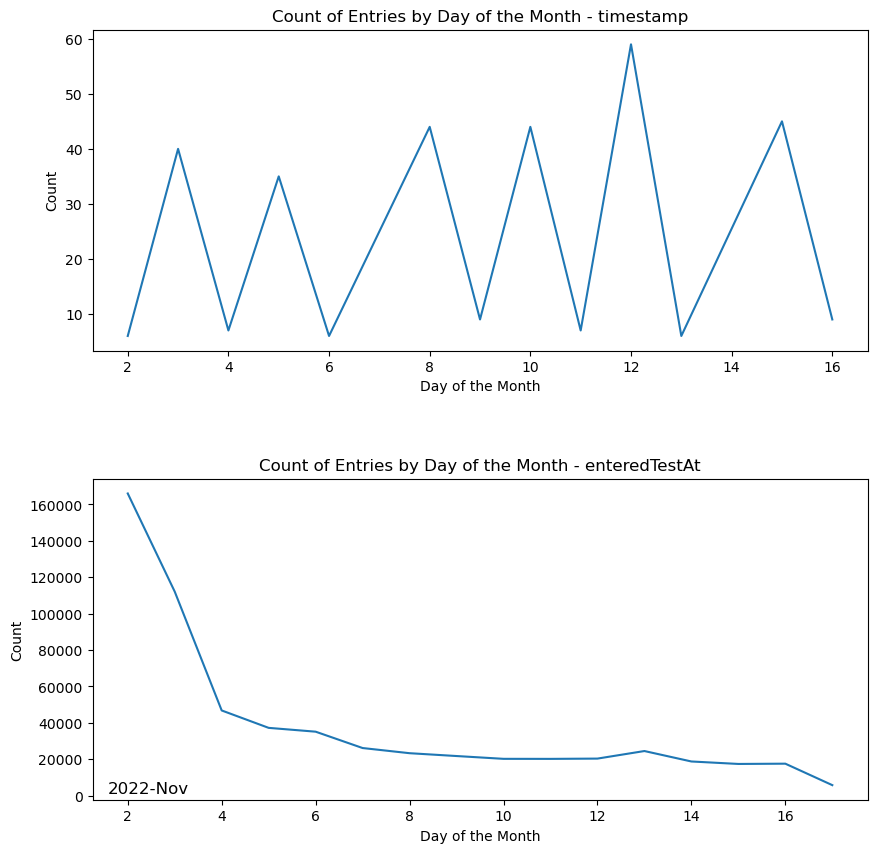

In [22]:
#subplots showing the total count of testing and transactions across days of the month 

# Extract day of the month from 'timestamp' and 'enteredTestAt' columns
df_conversion_rate['day_of_month_timestamp'] = df_conversion_rate['timestamp'].dt.day
df_conversion_rate['day_of_month_enteredTestAt'] = df_conversion_rate['enteredTestAt'].dt.day

# Group by 'day_of_month' and count the number of entries for 'timestamp'
count_by_day_timestamp = df_conversion_rate.groupby('day_of_month_timestamp').size()

# Group by 'day_of_month' and count the number of entries for 'enteredTestAt'
count_by_day_enteredTestAt = df_conversion_rate.groupby('day_of_month_enteredTestAt').size()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot count by day of the month for 'timestamp' on the first subplot
count_by_day_timestamp.plot(kind='line', ax=ax1, label='timestamp')
ax1.set_xlabel('Day of the Month')
ax1.set_ylabel('Count')
ax1.set_title('Count of Entries by Day of the Month - timestamp')

# Plot count by day of the month for 'enteredTestAt' on the second subplot
count_by_day_enteredTestAt.plot(kind='line', ax=ax2, label='enteredTestAt')
ax2.set_xlabel('Day of the Month')
ax2.set_ylabel('Count')
ax2.set_title('Count of Entries by Day of the Month - enteredTestAt')

# Display year and month in the bottom left corners of the plots
year_month_timestamp = df_conversion_rate['timestamp'].dt.strftime('%Y-%b').unique()[0]
year_month_enteredTestAt = df_conversion_rate['enteredTestAt'].dt.strftime('%Y-%b').unique()[0]
ax2.text(0.02, 0.02, year_month_enteredTestAt, transform=ax2.transAxes, fontsize=12)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Display the plots
plt.show()


Conduct power analysis 
--

In [23]:
#import required packages

from statsmodels.stats.power import TTestIndPower

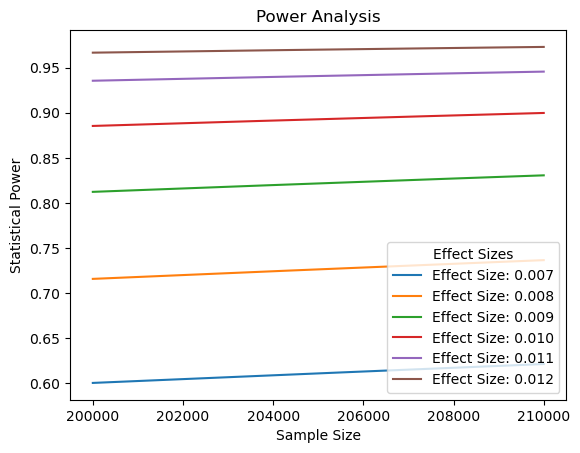

In [24]:
# Power analysis varying parameters
effect_sizes = np.array([0.007,0.008, 0.009, 0.01, 0.011, 0.012])
sample_sizes = np.array(range(200000, 210000))

# Plot power curves
obj = TTestIndPower()
fig, ax = plt.subplots()
for effect_size in effect_sizes:
    power = obj.power(effect_size=effect_size, nobs1=sample_sizes, alpha=0.05)
    label = f"Effect Size: {effect_size:.3f}"
    ax.plot(sample_sizes, power, label=label)

# Customize the legend to show unrounded effect sizes
ax.legend(title='Effect Sizes', loc='lower right')
plt.gca().get_legend().get_title().set_fontsize('10')  # Adjust legend title font size

# Label the axes
plt.xlabel('Sample Size')
plt.ylabel('Statistical Power')

# Add a title
plt.title('Power Analysis')

# Display the plot
plt.show()



Analysis
--

Conversion rate

In [25]:
#import required packages
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [26]:
##money generated from each variant

money_a= 102*24.99
money_b=118*24.99
money_c=97*24.99

print('Total revenue generated from all variants: £', (money_a + money_b + money_c))
print('Total revenue from variant A: £', money_a)
print('Total revenue from variant B: £', money_b)
print('Total revenue from variant C: £', money_c)

Total revenue generated from all variants: £ 7921.829999999999
Total revenue from variant A: £ 2548.98
Total revenue from variant B: £ 2948.8199999999997
Total revenue from variant C: £ 2424.0299999999997


In [27]:
#calculate conversion rate 

variant_count = df_conversion_rate['variant'].value_counts()
variant_with_timestamp_count = df_conversion_rate[df_conversion_rate['timestamp'].notna()]['variant'].value_counts()
percentage_with_timestamp = (variant_with_timestamp_count / variant_count) * 100
print(percentage_with_timestamp)

A    0.050268
B    0.058262
C    0.046531
Name: variant, dtype: float64


In [28]:
#calculate chi-squared from contingency table 

# Define the observed frequencies
observed = np.array([[102, 202812], [118, 202416], [97, 208365]])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(observed)

# Print the results
print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p)

Chi-square statistic: 2.8490232418671195
Degrees of freedom: 2
P-value: 0.24062595119407593


In [29]:
#fit logistic regression model 

logistic_df= df_conversion_rate[['variant','converted']]

# Convert the predictor variable into dummy/indicator variables
data = pd.get_dummies(logistic_df, columns=['variant'], drop_first=True)

# Split the data into predictor (X) and outcome (y) variables
X = data.drop('converted', axis=1)
y = data['converted']

# Add a constant term to the predictor variables
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print the summary of the logistic regression model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.004422
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               613910
Model:                          Logit   Df Residuals:                   613907
Method:                           MLE   Df Model:                            2
Date:                Sun, 09 Jul 2023   Pseudo R-squ.:               0.0005185
Time:                        12:13:50   Log-Likelihood:                -2714.8
converged:                       True   LL-Null:                       -2716.2
Covariance Type:            nonrobust   LLR p-value:                    0.2445
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.5951      0.099    -76.687      0.000      -7.789      -7.401
variant_B      0.1477      0

In [30]:
odds_ratios = np.exp(result.params)
print(odds_ratios)

const        0.000503
variant_B    1.159126
variant_C    0.925636
dtype: float64


Conversion time

In [31]:
# Calculate the mean time for each category
mean_time = df_conversion_rate.groupby('variant')['sec_diff'].mean()

print(mean_time)

variant
A    521432.018713
B    522015.842047
C    436557.517154
Name: sec_diff, dtype: float64


Shapiro-Wilk test for A
Test statistic: 0.9373728632926941
p-value: 0.00011412366438889876

Shapiro-Wilk test for B
Test statistic: 0.9376968741416931
p-value: 3.487906724330969e-05

Shapiro-Wilk test for C
Test statistic: 0.918919563293457
p-value: 1.6305282770190388e-05



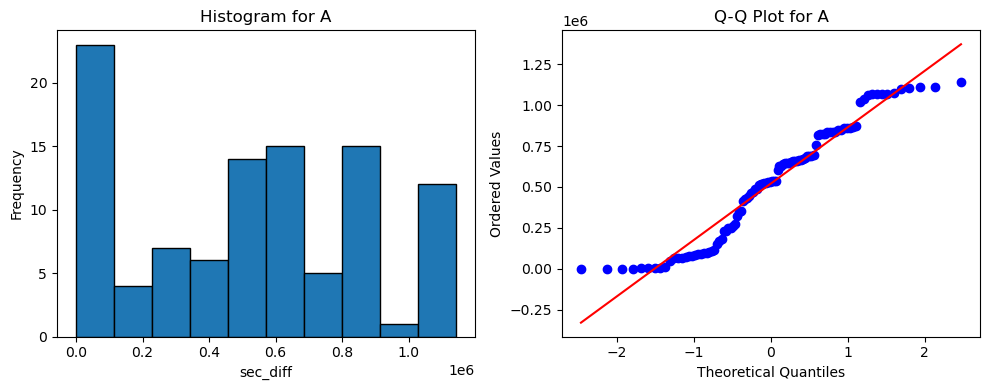

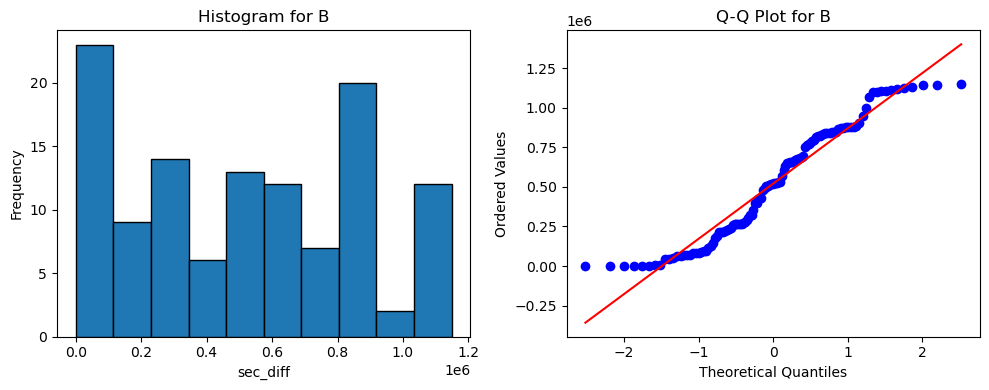

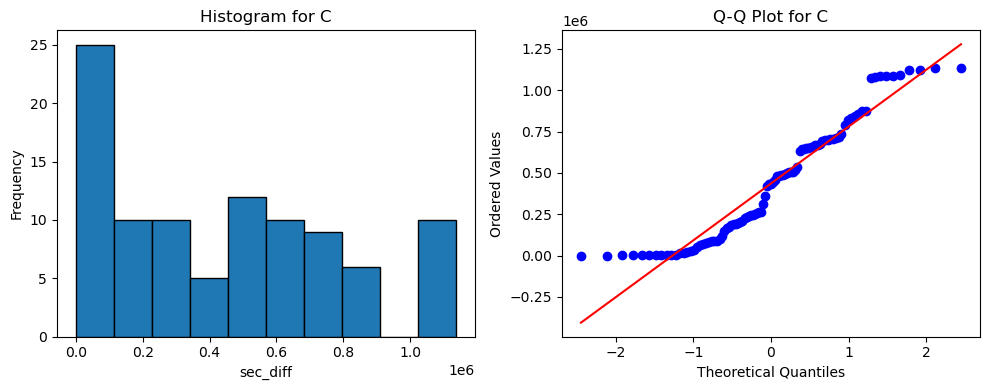

In [32]:
# Group the data by the 'variant' column
grouped_data = df_converted.groupby('variant')['sec_diff']

# Perform Shapiro-Wilk test for each group
for group, data in grouped_data:
    print("Shapiro-Wilk test for", group)
    statistic, p_value = stats.shapiro(data)
    print("Test statistic:", statistic)
    print("p-value:", p_value)
    print("")

# Create histograms and Q-Q plots for each group
for group, data in grouped_data:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Histogram
    axes[0].hist(data, bins=10, edgecolor='black')
    axes[0].set_title('Histogram for ' + group)
    axes[0].set_xlabel('sec_diff')
    axes[0].set_ylabel('Frequency')
    
    # Q-Q plot
    stats.probplot(data, dist='norm', plot=axes[1])
    axes[1].set_title('Q-Q Plot for ' + group)
    axes[1].set_xlabel('Theoretical Quantiles')
    axes[1].set_ylabel('Ordered Values')
    
    plt.tight_layout()
    plt.show()



In [33]:
 #Extract the values for each group
data = [grouped_data.get_group('A').values,
        grouped_data.get_group('B').values,
        grouped_data.get_group('C').values]

# Perform Kruskal-Wallis test
statistic, p_value = stats.kruskal(*data)

# Print the results
print("Kruskal-Wallis test results:")
print("Test statistic:", statistic)
print("p-value:", p_value)

Kruskal-Wallis test results:
Test statistic: 4.483303447898152
p-value: 0.1062828094576858


In [44]:
#normalise the data and fit linear regression

# Convert categorical variable using one-hot encoding
df_encoded = pd.get_dummies(df_converted, columns=['variant'])

# Separate predictor and response variables
X = df_encoded[['variant_A','variant_B','variant_C']]
y = df_encoded['sec_diff']

# Normalize numerical columns
numerical_columns = X.columns
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Fit linear regression model
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

# Print the model summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               sec_diff   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.978
Date:                Sun, 09 Jul 2023   Prob (F-statistic):              0.140
Time:                        14:48:35   Log-Likelihood:                -4496.3
No. Observations:                 317   AIC:                             8999.
Df Residuals:                     314   BIC:                             9010.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.957e+05   1.97e+04     25.116      0.0

C:\Users\44753\AppData\Local\Temp\ipykernel_36128\2058093084.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_columns] = scaler.fit_transform(X[numerical_columns])


In [35]:
#view results of linear regression

# View coefficients
coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': model.coef_})
print(coefficients)

# View intercept
intercept = model.intercept_
print('Intercept:', intercept)

# Make predictions
predictions = model.predict(X)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

# Mean Squared Error (MSE)
mse = mean_squared_error(y, predictions)
print('Mean Squared Error:', mse)

# R-squared
r2 = r2_score(y, predictions)
print('R-squared:', r2)

    Variable   Coefficient
0  variant_A  12579.625034
1  variant_B  13299.371644
2  variant_C -26703.212980
Intercept: 495678.2789722082
Mean Squared Error: 122299414653.82259
R-squared: 0.012444651550471586


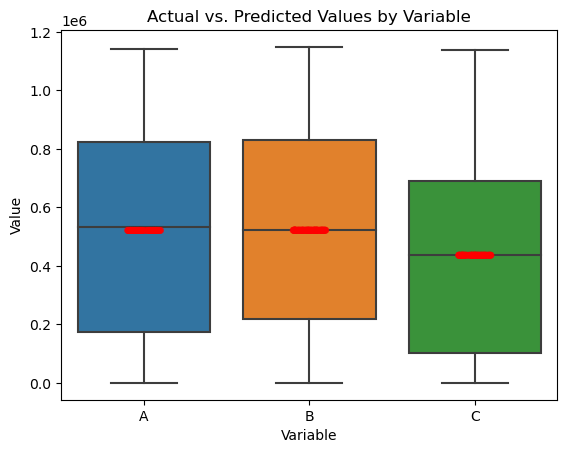

In [36]:
#visualise linear regression results

# Create a DataFrame for actual and predicted values
results = pd.DataFrame({'Actual': y, 'Predicted': predictions, 'Variable': df_converted['variant']})

# Sort the 'Variable' column in alphabetical order
results_sorted = results.sort_values('Variable')

# Create a box plot for each categorical variable
sns.boxplot(x='Variable', y='Actual', data=results_sorted)
sns.stripplot(x='Variable', y='Predicted', data=results_sorted, color='red', alpha=0.5)

plt.xlabel('Variable')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values by Variable')
plt.show()
